In [16]:
# Notebook: problem 2 written report 
# Author: Ben Bernal
# Date: 12JUL2024

### Preliminaries

#### Libraries

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from os import path, listdir
from pprint import pprint
import re
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dataclasses import make_dataclass

#### Utilities

In [2]:
from utilities import json as util_json

#### Configuration

In [3]:
env_config = util_json.to_dict(
    file_path="../../config/env.json"
)

# Investigating a Time-Varying Criminal Network

## DataSet

In [4]:
data_pointer = path.normpath(
                    path.join(
                        env_config['root'],
                        "modules/m3/CAVIAR"
                    )
                )
phases_lst = listdir(
                path= data_pointer
            )

pprint(phases_lst)

['phase6.csv',
 'phase7.csv',
 'phase5.csv',
 'phase4.csv',
 'phase10.csv',
 'phase11.csv',
 'phase1.csv',
 'phase3.csv',
 'phase2.csv',
 'phase9.csv',
 'phase8.csv']


In [5]:
frame_lst = [
    pd.read_csv(
        filepath_or_buffer=path.normpath(
            path.join(
                data_pointer,
                phase_file
            )
        ),
        index_col=[0]
    )
    for phase_file in phases_lst
]

In [6]:
graph_dict = {}

for phase_str in phases_lst:

    var_name = re.split(
        pattern=r"\.",
        string=phase_str
    )[0]

    tmp_frame = pd.read_csv(
        filepath_or_buffer=path.normpath(
            path.join(
                data_pointer,
                phase_str
            )
        ),
        index_col=[0]
    )

    tmp_frame.columns = "n" + tmp_frame.columns

    tmp_frame.index = tmp_frame.columns

    tmp_frame[tmp_frame > 0] = 1

    graph_dict[var_name] = nx.from_pandas_adjacency(tmp_frame)

    # break

## Network Size

In [7]:
NetworkSize = make_dataclass(
    "NetworkSize",
    [   
        ("phase_str", str),
        ("phase", int),
        ("nodes", int),
        ("edges", int),
    ]
)

phases_frame = pd.DataFrame(
                            [
                                NetworkSize(
                                    key,
                                    int(
                                        re.split(
                                            pattern=r"se",
                                            string=key
                                        )[1]
                                    ),
                                    graph.number_of_nodes(),
                                    graph.number_of_edges()
                                )
                                for key, graph in graph_dict.items()
                            ]
                        )

In [8]:
phases_frame

,phase_str,phase,nodes,edges
0,phase6,6,27,47
1,phase7,7,36,49
2,phase5,5,32,39
3,phase4,4,33,48
4,phase10,10,42,50
5,phase11,11,41,50
6,phase1,1,15,18
7,phase3,3,33,56
8,phase2,2,24,28
9,phase9,9,34,44


In [9]:
melted_phase_frame = pd.melt(
    frame=phases_frame.sort_values(by=['phase']),
    id_vars=['phase'],
    value_vars=['nodes', 'edges'],
    value_name='size',
    var_name='network attribute'
)

In [10]:
melted_phase_frame.sample(2)

,phase,network attribute,size
4,5,nodes,32
6,7,nodes,36


In [11]:
fig = px.line(
    melted_phase_frame,
    x = 'phase',
    y = 'size',
    color = 'network attribute',
    symbol = 'network attribute',
)

fig.show()

## Visualization

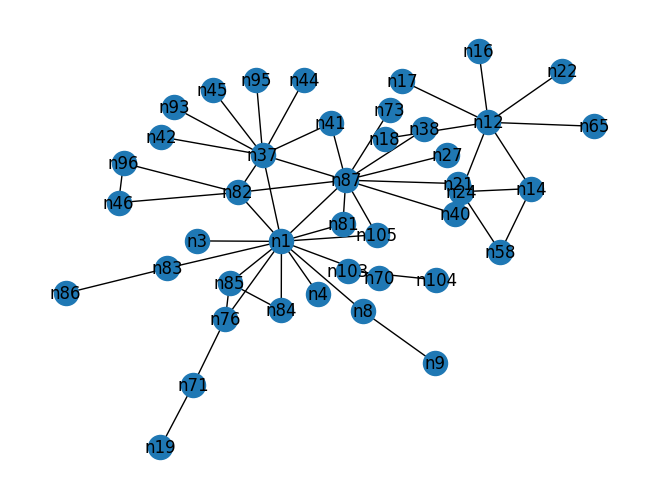

In [59]:
g = graph_dict['phase10']
nx.draw(g, pos=nx.drawing.nx_agraph.graphviz_layout(g), with_labels=True) 

## Temporal Consistency

In [12]:
Node = make_dataclass(
    "Node",
    [
        ("player", str),
        ("phase", int),
        ("phase_str", str),
        ("normalized_degree_centrality", float),
        ("normalized_betweeness_centrality", float),
        ("eigenvector_centrality", float)
    ]
)

In [13]:
node_obj_lst = []

for phase_str, graph in graph_dict.items():

    print("Now analyzing phase, ", phase_str)

    phase = int(re.split(
        pattern=r"se",
        string=phase_str
    )[1])

    print("\nTransformed to integer for order, ", phase)

    ec_dict = nx.eigenvector_centrality(G=graph_dict[phase_str])

    bc_dict = nx.betweenness_centrality(G=graph_dict[phase_str], normalized=True)

    dc_dict = nx.degree_centrality(G=graph_dict[phase_str])

    print("\nAll centrality measures have been calculated")

    for i in range(1, 111):

        node_key = f"n{i}"

        node_obj_lst.append(
            Node(
                node_key,
                phase,
                phase_str,
                dc_dict.get(node_key, 0.0),
                bc_dict.get(node_key, 0.0),
                ec_dict.get(node_key, 0.0)
            )
        )


    # break

Now analyzing phase,  phase6

Transformed to integer for order,  6

All centrality measures have been calculated
Now analyzing phase,  phase7

Transformed to integer for order,  7

All centrality measures have been calculated
Now analyzing phase,  phase5

Transformed to integer for order,  5

All centrality measures have been calculated
Now analyzing phase,  phase4

Transformed to integer for order,  4

All centrality measures have been calculated
Now analyzing phase,  phase10

Transformed to integer for order,  10

All centrality measures have been calculated
Now analyzing phase,  phase11

Transformed to integer for order,  11

All centrality measures have been calculated
Now analyzing phase,  phase1

Transformed to integer for order,  1

All centrality measures have been calculated
Now analyzing phase,  phase3

Transformed to integer for order,  3

All centrality measures have been calculated
Now analyzing phase,  phase2

Transformed to integer for order,  2

All centrality measures 

In [14]:
frame = pd.DataFrame(node_obj_lst)

In [15]:
node_stats = frame.groupby(['player']).describe()

## Degree Centrality

In [35]:
dc_frame = (
    node_stats[[('normalized_degree_centrality', 'mean')]]
    .reset_index(col_level = 1)
    .droplevel(0, axis = 1)
    .sort_values(by = ['mean'], ascending = False)
    .reset_index(drop=True)
    .rename(columns = {'mean':'averaged_normalized_degree_centrality'})
    .assign(
        cummulative_sum = lambda X: X.averaged_normalized_degree_centrality.cumsum(),
        cumulative_percent = lambda X: (X.cummulative_sum / X.averaged_normalized_degree_centrality.sum()) * 100
    )
)


In [36]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Bar(
        x = dc_frame.player,
        y = dc_frame.averaged_normalized_degree_centrality,
        name = "Averaged (Normalized) Degree Centrality"
    ),
    secondary_y = False
)
fig.add_trace(
    go.Scatter(
        x = dc_frame.player,
        y = dc_frame.cumulative_percent,
        name = "Cumulative Percentage"
    ),
    secondary_y = True
)
fig.add_hline(
    y = 80,
    secondary_y = True,
    line_width=1,
    line_dash="dash"
)
fig.add_vline(
    x = 'n31',
    secondary_y = True,
    line_width=1,
    line_dash="dash"
)
fig.update_layout(legend=dict(
    orientation="h",
    # entrywidth=70,
    yanchor="bottom",
    y=-0.3,
    xanchor="right",
    x=0.95
))
fig.update_layout(
    title_text = "Pareto Chart For Criminal Network: (Normalized) Degree Centrality Averaged over all Investigation Phases"
)
fig.show()

## Betweeness Centrality 

In [37]:
dc_frame = (
    node_stats[[('normalized_betweeness_centrality', 'mean')]]
    .reset_index(col_level = 1)
    .droplevel(0, axis = 1)
    .sort_values(by = ['mean'], ascending = False)
    .reset_index(drop=True)
    .rename(columns = {'mean':'averaged_normalized_betweeness_centrality'})
    .assign(
        cummulative_sum = lambda X: X.averaged_normalized_betweeness_centrality.cumsum(),
        cumulative_percent = lambda X: (X.cummulative_sum / X.averaged_normalized_betweeness_centrality.sum()) * 100
    )
)


In [38]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Bar(
        x = dc_frame.player,
        y = dc_frame.averaged_normalized_betweeness_centrality,
        name = "Averaged (Normalized) Betweeness Centrality"
    ),
    secondary_y = False
)
fig.add_trace(
    go.Scatter(
        x = dc_frame.player,
        y = dc_frame.cumulative_percent,
        name = "Cumulative Percentage"
    ),
    secondary_y = True
)
fig.add_hline(
    y = 80,
    secondary_y = True,
    line_width=1,
    line_dash="dash"
)
fig.add_vline(
    x = 'n31',
    secondary_y = True,
    line_width=1,
    line_dash="dash"
)
fig.update_layout(legend=dict(
    orientation="h",
    # entrywidth=70,
    yanchor="bottom",
    y=-0.3,
    xanchor="right",
    x=0.95
))
fig.update_layout(
    title_text = "Pareto Chart For Criminal Network: (Normalized) Betweeness Centrality Averaged over all Investigation Phases"
)
fig.show()

## Eigen Vector Centrality

In [39]:
dc_frame = (
    node_stats[[('eigenvector_centrality', 'mean')]]
    .reset_index(col_level = 1)
    .droplevel(0, axis = 1)
    .sort_values(by = ['mean'], ascending = False)
    .reset_index(drop=True)
    .rename(columns = {'mean':'averaged_eigenvector_centrality'})
    .assign(
        cummulative_sum = lambda X: X.averaged_eigenvector_centrality.cumsum(),
        cumulative_percent = lambda X: (X.cummulative_sum / X.averaged_eigenvector_centrality.sum()) * 100
    )
)


In [40]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Bar(
        x = dc_frame.player,
        y = dc_frame.averaged_eigenvector_centrality,
        name = "Averaged Eigenvector Centrality"
    ),
    secondary_y = False
)
fig.add_trace(
    go.Scatter(
        x = dc_frame.player,
        y = dc_frame.cumulative_percent,
        name = "Cumulative Percentage"
    ),
    secondary_y = True
)
fig.add_hline(
    y = 80,
    secondary_y = True,
    line_width=1,
    line_dash="dash"
)
fig.add_vline(
    x = 'n31',
    secondary_y = True,
    line_width=1,
    line_dash="dash"
)
fig.update_layout(legend=dict(
    orientation="h",
    # entrywidth=70,
    yanchor="bottom",
    y=-0.3,
    xanchor="right",
    x=0.95
))
fig.update_layout(
    title_text = "Pareto Chart For Criminal Network: Eigenvector Centrality Averaged over all Investigation Phases"
)
fig.show()

## Centrality Ranking

In [50]:
graph_frame = frame.query("phase==4 or phase==5").sort_values(by=['phase_str'])
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n1'")['phase_str'],
        y = graph_frame.query("player=='n1'")['normalized_degree_centrality'],
        name="n1"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n12'")['phase_str'],
        y = graph_frame.query("player=='n12'")['normalized_degree_centrality'],
        name="n12"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n89'")['phase_str'],
        y = graph_frame.query("player=='n89'")['normalized_degree_centrality'],
        name="n89"

    )
)
fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text = 'Normalized Degree Centrality Change')
fig.show()

In [51]:
graph_frame = frame.query("phase==4 or phase==5").sort_values(by=['phase_str'])
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n1'")['phase_str'],
        y = graph_frame.query("player=='n1'")['normalized_betweeness_centrality'],
        name="n1"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n12'")['phase_str'],
        y = graph_frame.query("player=='n12'")['normalized_betweeness_centrality'],
        name="n12"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n89'")['phase_str'],
        y = graph_frame.query("player=='n89'")['normalized_betweeness_centrality'],
        name="n89"

    )
)
fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text = 'Normalized Betweeness Centrality Change')
fig.show()

In [52]:
graph_frame = frame.query("phase==4 or phase==5").sort_values(by=['phase_str'])
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n1'")['phase_str'],
        y = graph_frame.query("player=='n1'")['eigenvector_centrality'],
        name="n1"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n12'")['phase_str'],
        y = graph_frame.query("player=='n12'")['eigenvector_centrality'],
        name="n12"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n89'")['phase_str'],
        y = graph_frame.query("player=='n89'")['eigenvector_centrality'],
        name="n89"

    )
)
fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text = 'Eigenvector Centrality Change')
fig.show()

In [42]:
frame.columns

Index(['player', 'phase', 'phase_str', 'normalized_degree_centrality',
       'normalized_betweeness_centrality', 'eigenvector_centrality'],
      dtype='object')

## Network changes

In [65]:
graph_frame = frame.sort_values(by=['phase'])
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n1'")['phase_str'],
        y = graph_frame.query("player=='n1'")['normalized_degree_centrality'],
        name="n1"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n3'")['phase_str'],
        y = graph_frame.query("player=='n3'")['normalized_degree_centrality'],
        name="n3"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n85'")['phase_str'],
        y = graph_frame.query("player=='n85'")['normalized_degree_centrality'],
        name="n85"

    )
)
fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text = 'Degree Centrality Change')
fig.show()

## Project

In [16]:
graph_frame = frame.sort_values(by=['phase'])
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n6'")['phase_str'],
        y = graph_frame.query("player=='n6'")['normalized_degree_centrality'],
        name="n6: brooker in Spain"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n11'")['phase_str'],
        y = graph_frame.query("player=='n11'")['normalized_degree_centrality'],
        name="n11: provider in Morocco"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n84'")['phase_str'],
        y = graph_frame.query("player=='n84'")['normalized_degree_centrality'],
        name="n84: Moroccan investor"

    )
)
fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text = 'Degree Centrality Change: trafficking route change')
fig.show()

In [17]:
graph_frame = frame.sort_values(by=['phase'])
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n6'")['phase_str'],
        y = graph_frame.query("player=='n6'")['normalized_betweeness_centrality'],
        name="n6: brooker in Spain"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n11'")['phase_str'],
        y = graph_frame.query("player=='n11'")['normalized_betweeness_centrality'],
        name="n11: provider in Morocco"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n84'")['phase_str'],
        y = graph_frame.query("player=='n84'")['normalized_betweeness_centrality'],
        name="n84: Moroccan investor"

    )
)
fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text = 'Betweeness Centrality Change: trafficking route change')
fig.show()

In [18]:
graph_frame = frame.sort_values(by=['phase'])
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n6'")['phase_str'],
        y = graph_frame.query("player=='n6'")['eigenvector_centrality'],
        name="n6: brooker in Spain"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n11'")['phase_str'],
        y = graph_frame.query("player=='n11'")['eigenvector_centrality'],
        name="n11: provider in Morocco"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n84'")['phase_str'],
        y = graph_frame.query("player=='n84'")['eigenvector_centrality'],
        name="n84: Moroccan investor"

    )
)
fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text = 'Eigenvector Centrality Change: trafficking route change')
fig.show()

In [19]:
graph_frame = frame.sort_values(by=['phase'])
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n12'")['phase_str'],
        y = graph_frame.query("player=='n12'")['eigenvector_centrality'],
        name="n12: logistics chief Colombian route"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n80'")['phase_str'],
        y = graph_frame.query("player=='n80'")['eigenvector_centrality'],
        name="n80: transport US-Canada"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n33'")['phase_str'],
        y = graph_frame.query("player=='n33'")['eigenvector_centrality'],
        name="n33: cocaine keeper in US"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n16'")['phase_str'],
        y = graph_frame.query("player=='n16'")['eigenvector_centrality'],
        name="n16: cocaine provider"

    )
)
fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text = 'Eigenvector Centrality Change: trafficking route change')
fig.show()

In [20]:
graph_frame = frame.sort_values(by=['phase'])
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n3'")['phase_str'],
        y = graph_frame.query("player=='n3'")['normalized_degree_centrality'],
        name="n3: degree centrality"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n3'")['phase_str'],
        y = graph_frame.query("player=='n3'")['normalized_betweeness_centrality'],
        name="n3: betweeness centrality"

    )
)
fig.add_trace(
    go.Bar(
        x = graph_frame.query("player=='n3'")['phase_str'],
        y = graph_frame.query("player=='n3'")['eigenvector_centrality'],
        name="n3: eigenvector centrality"

    )
)

fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text = 'Centrality Change: rise & fall of n3')
fig.show()